In [261]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from skimage.exposure import equalize_hist
from skimage.filters.rank import median
from skimage.measure import regionprops
from skimage.morphology import disk
from skimage.segmentation import felzenszwalb
from skimage.transform import rescale
from skimage.util import img_as_ubyte
from scipy.ndimage import binary_fill_holes
#from scipy.misc import imresize
from PIL import Image

In [262]:
def breast_segment(im, scale_factor=0.25, threshold=3900, felzenzwalb_scale=0.15):
    """
    Fully automated breast segmentation in mammographies.
    https://github.com/olieidel/breast_segment
    :param im: Image
    :param scale_factor: Scale Factor
    :param threshold: Threshold
    :param felzenzwalb_scale: Felzenzwalb Scale
    :return: (im_mask, bbox) where im_mask is the segmentation mask and
    bbox is the bounding box (rectangular) of the segmentation.
    """

    # set threshold to remove artifacts around edges
    im_thres = im.copy()
    im_thres[im_thres > threshold] = 0
    
    # determine breast side
    col_sums_split = np.array_split(np.sum(im_thres, axis=0), 2)
    left_col_sum = np.sum(col_sums_split[0])
    right_col_sum = np.sum(col_sums_split[1])
    
    if left_col_sum > right_col_sum:
        breast_side = 'l'
    else:
        breast_side = 'r'
    
    # rescale and filter aggressively, normalize
    im_small = rescale(im_thres, scale_factor)
    im_small = img_as_ubyte(im_small)
    im_small_filt = median(im_small, disk(25))   #50
    # this might not be helping, actually sometimes it is
    im_small_filt = equalize_hist(im_small_filt)
   
    # run felzenzwalb
    segments = felzenszwalb(im_small_filt, scale=felzenzwalb_scale)
    segments += 1  # otherwise, labels() would ignore segment with segment=0
    
    props = regionprops(segments)
    
    # Sort Props by area, descending
    props_sorted = sorted(props, key=lambda x: x.area, reverse=True)

    expected_bg_index = 0 #0
    bg_index = expected_bg_index

    bg_region = props_sorted[bg_index]
    minr, minc, maxr, maxc = bg_region.bbox
    filled_mask = bg_region.filled_image

    im_small_fill = np.zeros((im_small_filt.shape[0]+2, im_small_filt.shape[1]+1), dtype=int)

    if breast_side == 'l':
        # breast expected to be on left side,
        # pad on right and bottom side
        im_small_fill[minr+1:maxr+1, minc:maxc] = filled_mask
        im_small_fill[0, :] = 1  # top
        im_small_fill[-1, :] = 1  # bottom
        im_small_fill[:, -1] = 1  # right
    elif breast_side == 'r':
        # breast expected to be on right side,
        # pad on left and bottom side
        im_small_fill[minr+1:maxr+1, minc+1:maxc+1] = filled_mask  # shift mask to right side
        im_small_fill[0, :] = 1  # top
        im_small_fill[-1, :] = 1  # bottom
        im_small_fill[:, 0] = 1  # left

    im_small_fill = binary_fill_holes(im_small_fill)

    im_small_mask = im_small_fill[1:-1, :-1] if breast_side == 'l' \
                  else im_small_fill[1:-1, 1:]

    # rescale mask
    shape = (im.shape[1],im.shape[0])
    im_mask = np.array(Image.fromarray(im_small_mask).resize(shape)).astype(bool)
    # invert!
    im_mask = ~im_mask
    
    # determine side of breast in mask and compare
    col_sums_split = np.array_split(np.sum(im_mask, axis=0), 2)
    left_col_sum = np.sum(col_sums_split[0])
    right_col_sum = np.sum(col_sums_split[1])

    if left_col_sum > right_col_sum:
        breast_side_mask = 'l'
    else:
        breast_side_mask = 'r'

    if breast_side_mask != breast_side:
        # breast mask is not on expected side
        # we might have segmented bg instead of breast
        # so invert again
        print('breast and mask side mismatch. inverting!')
        im_mask = ~im_mask

    # if no region found, abort early and return mask of complete image
    if im_mask.ravel().sum() == 0:
        all_mask = np.ones_like(im).astype(bool)
        bbox = (0, 0, im.shape[0], im.shape[1])
        print('Couldn\'t find any segment')
        return all_mask, bbox

    # get bbox
    minr = np.argwhere(im_mask.any(axis=1)).ravel()[0]
    maxr = np.argwhere(im_mask.any(axis=1)).ravel()[-1]
    minc = np.argwhere(im_mask.any(axis=0)).ravel()[0]
    maxc = np.argwhere(im_mask.any(axis=0)).ravel()[-1]

    bbox = (minr, minc, maxr, maxc)

    return im_mask, bbox

In [263]:
im_files = []
for folder in os.listdir('.\images'):
    for file in os.listdir(f'.\images\\{folder}'):
        im_files.append(f'.\images\\{folder}\\{file}')
print(im_files)

['.\\images\\10006\\1459541791.dcm', '.\\images\\10006\\1864590858.dcm', '.\\images\\10006\\1874946579.dcm', '.\\images\\10006\\462822612.dcm', '.\\images\\10011\\1031443799.dcm', '.\\images\\10011\\220375232.dcm', '.\\images\\10011\\270344397.dcm', '.\\images\\10011\\541722628.dcm', '.\\images\\10025\\1365269360.dcm', '.\\images\\10025\\288394860.dcm', '.\\images\\10025\\562340703.dcm', '.\\images\\10025\\893612858.dcm', '.\\images\\10038\\1350492010.dcm', '.\\images\\10038\\1967300488.dcm', '.\\images\\10038\\2142944869.dcm', '.\\images\\10038\\850559196.dcm', '.\\images\\10042\\102733848.dcm', '.\\images\\10042\\1648588715.dcm', '.\\images\\10042\\202939811.dcm', '.\\images\\10042\\294481519.dcm', '.\\images\\10042\\495770405.dcm', '.\\images\\10130\\1013166704.dcm', '.\\images\\10130\\1165309236.dcm', '.\\images\\10130\\1360338805.dcm', '.\\images\\10130\\1672636630.dcm', '.\\images\\10130\\2110820077.dcm', '.\\images\\10130\\388811999.dcm', '.\\images\\10130\\613462606.dcm']


In [264]:
imgs = []
for file in im_files:
    ds = pydicom.dcmread(file) #Read .dcm file
    imgs.append(np.array(ds.pixel_array, dtype=np.uint8))

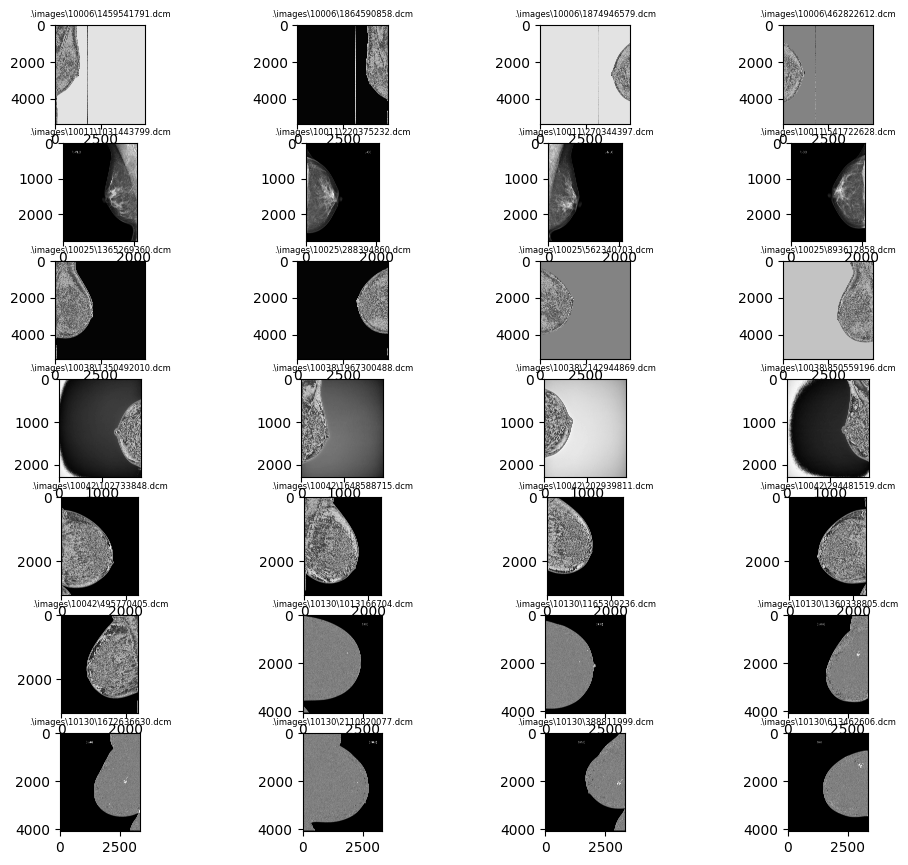

In [265]:
%matplotlib inline
plt.figure(figsize=(12,12))
for i, img in enumerate(imgs):
    plt.subplot(len(imgs)//4 + 1, 4, i+1)
    plt.title(im_files[i], fontsize=6)
    plt.imshow(img, cmap='gray')

Couldn't find any segment
breast and mask side mismatch. inverting!
Couldn't find any segment
breast and mask side mismatch. inverting!
breast and mask side mismatch. inverting!
breast and mask side mismatch. inverting!


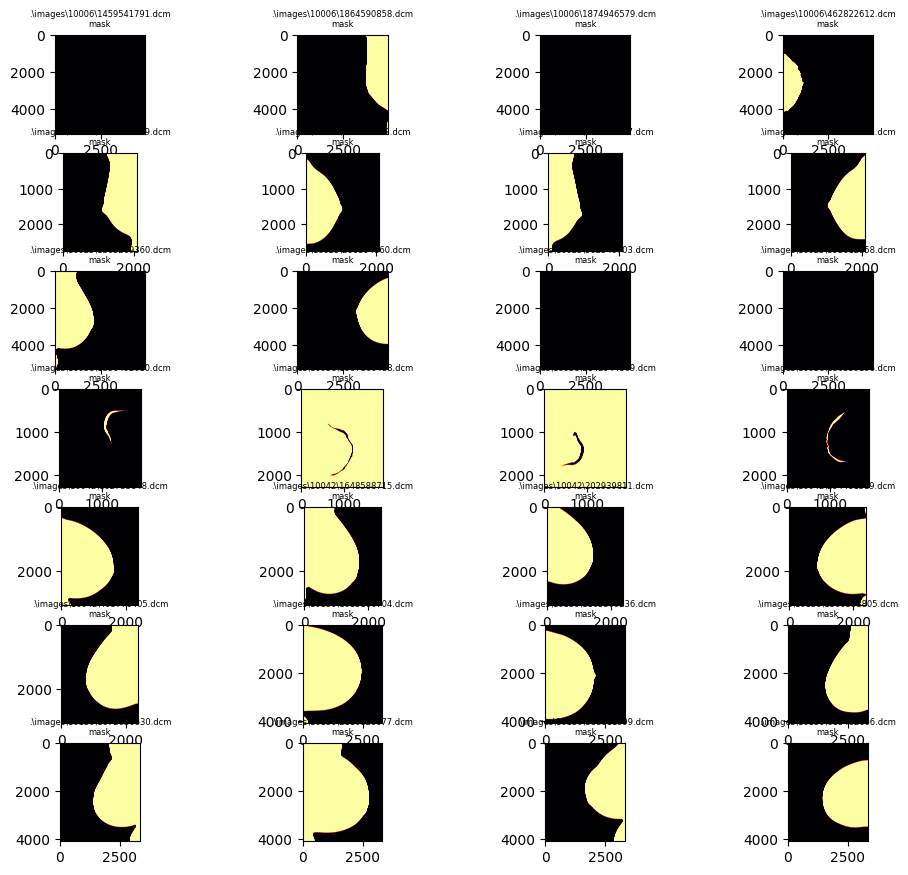

In [266]:
%matplotlib inline
masks_bboxes = []
plt.figure(figsize=(12,12))
for i, img in enumerate(imgs):
    mask, bbox = breast_segment(img, scale_factor=.25, threshold=30000)
    masks_bboxes.append((mask,bbox))
    plt.subplot(len(imgs)//4 + 1, 4, i+1)
    plt.title(im_files[i] + '\nmask', fontsize=6)
    plt.imshow(mask, cmap='inferno')

In [267]:
def get_segment_crop(image,tol=0, mask=None):
    if mask is None:
        mask = image > tol
    return image[np.ix_(mask.any(1), mask.any(0))]

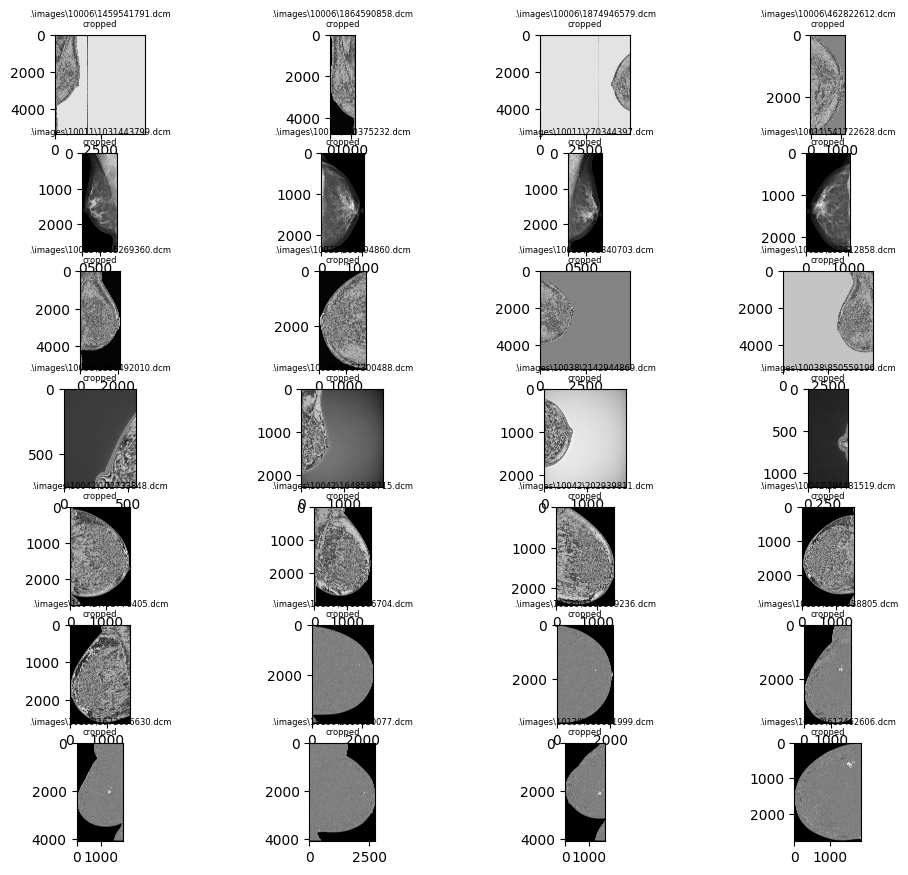

In [268]:
%matplotlib inline
tts = []
plt.figure(figsize=(12,12))
for i, img in enumerate(imgs):
    tt = get_segment_crop(img, mask=masks_bboxes[i][0])
    tts.append(tt)
    plt.subplot(len(imgs)//4 + 1, 4, i+1)
    plt.title(im_files[i] + '\ncropped', fontsize=6)
    plt.imshow(tt, cmap='gray')

In [269]:
def histogram_equalization(img):
    m = int(np.max(img))
    hist = np.histogram(img, bins=m+1, range=(0, m+1))[0]
    hist = hist/img.size
    cdf = np.cumsum(hist)
    s_k = (255 * cdf)
    img_new = np.array([s_k[i] for i in img.ravel()],dtype=np.uint8).reshape(img.shape)
    return img_new

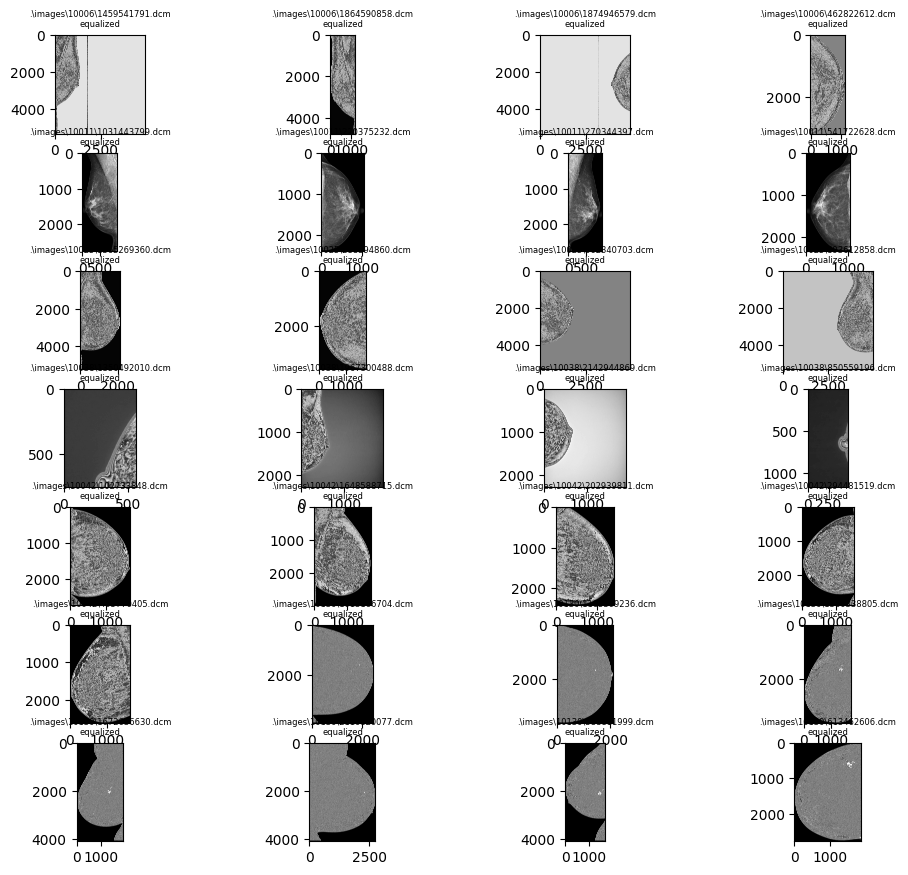

In [270]:
%matplotlib inline
plt.figure(figsize=(12,12))
for i, tt in enumerate(tts):
    img_eq = histogram_equalization(tt)
    plt.subplot(len(tts)//4 + 1, 4, i+1)
    plt.title(im_files[i] + '\nequalized', fontsize=6)
    plt.imshow(tt, cmap='gray')